# import the packages

In [1]:
import pandas as pd

# load the data

In [2]:
df = pd.read_csv('online_retail.csv',names=['invoice', 'sku', 'description', 'qty', 'order_date', 
                        'unit_price', 'customer_id', 'country'],
                low_memory=False, 
                skiprows=1, encoding= 'unicode_escape')
df.head()

,invoice,sku,description,qty,order_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# data preprocessing

In [3]:
df.isnull().sum()

invoice             0
sku                 0
description      1454
qty                 0
order_date          0
unit_price          0
customer_id    135080
country             0
dtype: int64

In [4]:
df=df.dropna()

In [5]:
df.isnull().sum()

invoice        0
sku            0
description    0
qty            0
order_date     0
unit_price     0
customer_id    0
country        0
dtype: int64

# feature engineering 
## This data set doesn’t include a line price, so to save hassle in later steps, we will first calculate this by multiplying the qty field by the unit_price field. The order_date field is also an object instead of a datetime, so we can reset this to the correct type using the Pandas to_datetime() function.

In [6]:
df['line_price'] = df['qty'] * df['unit_price']
df['order_date'] = pd.to_datetime(df['order_date'])

In [7]:
df.head()

,invoice,sku,description,qty,order_date,unit_price,customer_id,country,line_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [8]:
df_orders = df.groupby('invoice').agg(
    revenue=('line_price', 'sum'),
    skus=('sku', 'nunique'),
    items=('qty', 'sum'),
)

df_orders.head()

,revenue,skus,items
invoice,,,
536365,139.12,7,40
536366,22.20,2,12
536367,278.73,12,83
536368,70.05,4,15
536369,17.85,1,3


In [9]:
df_customers = df.groupby('customer_id').agg(
    revenue=('line_price', 'sum'),
    orders=('invoice', 'nunique'),
    skus=('sku', 'nunique'),
    units=('qty', 'sum'),
    first_order_date=('order_date', 'min'),
    last_order_date=('order_date', 'max')    
).reset_index().sort_values(by='revenue', ascending=False)

df_customers.head()

,customer_id,revenue,orders,skus,units,first_order_date,last_order_date
1703,14646.0,279489.02,77,703,196719,2010-12-20 10:09:00,2011-12-08 12:12:00
4233,18102.0,256438.49,62,151,64122,2010-12-07 16:42:00,2011-12-09 11:50:00
3758,17450.0,187482.17,55,127,69029,2010-12-07 09:23:00,2011-12-01 13:29:00
1895,14911.0,132572.62,248,1794,77180,2010-12-01 14:05:00,2011-12-08 15:54:00
55,12415.0,123725.45,26,444,77242,2011-01-06 11:12:00,2011-11-15 14:22:00


In [10]:
df_products = df.groupby('sku').agg(
    units=('qty', 'sum'),
    avg_units=('qty', 'mean'),    
    revenue=('line_price', 'sum'),
    orders=('invoice', 'nunique'),
    customers=('customer_id', 'nunique'),
)

df_products.head()

,units,avg_units,revenue,orders,customers
sku,,,,,
10002,823,16.795918,699.55,49,40
10080,291,13.857143,114.41,21,19
10120,193,6.433333,40.53,29,25
10123C,5,1.666667,3.25,3,3
10124A,16,3.200000,6.72,5,5


In [11]:
df_baskets = df[['invoice', 'sku', 'description', 'qty']]
df_baskets.head()

,invoice,sku,description,qty
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,71053,WHITE METAL LANTERN,6
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


# Examine the most popular product
## To get a handle on what are the most popular products, we can use groupby() and agg() to calculate some summary statistics for the products in this dataset. This shows us that the top-selling line is the WHITE HANGING HEART T-LIGHT HOLDER.

In [12]:
df.groupby('description').agg(
    orders=('invoice', 'nunique'),
    quantity=('qty', 'sum')
).sort_values(by='orders', ascending=False).head(10)

,orders,quantity
description,,
WHITE HANGING HEART T-LIGHT HOLDER,2013,34147
REGENCY CAKESTAND 3 TIER,1884,11555
JUMBO BAG RED RETROSPOT,1643,45066
PARTY BUNTING,1399,15027
ASSORTED COLOUR BIRD ORNAMENT,1385,35314
LUNCH BAG RED RETROSPOT,1329,17145
SET OF 3 CAKE TINS PANTRY DESIGN,1218,6864
POSTAGE,1194,3002
LUNCH BAG BLACK SKULL.,1073,11173


In [13]:
df_items = df_baskets.pivot_table(index='invoice', columns=['description'], values='qty').fillna(0)
df_items.head(3)

description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
invoice,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create product recommendations
## Finally, we can create a little helper function for our recommendation system to make it quick and easy to identify which products are associated with others. First, we use the corrwith() function to identify the Pearson correlation coefficient for each product with every other.

## When we run the get_recommendations() function we will pass in our item matrix dataframe containing each product and the number of times it co-occurred in a basket, as well as the column name for our target product. The recommender function will then calculate the Pearson correlation for the item and return the most correlated products, thus generating accurate product recs for us to display to the user on the product detail page, or present in an email to the user.



In [14]:
def get_recommendations(df, item):
    """Generate a set of product recommendations using item-based collaborative filtering.
    
    Args:
        df (dataframe): Pandas dataframe containing matrix of items purchased.
        item (string): Column name for target item. 
        
    Returns: 
        recommendations (dataframe): Pandas dataframe containing product recommendations. 
    """
    
    recommendations = df.corrwith(df[item])
    recommendations = pd.DataFrame(recommendations, columns=['correlation']).reset_index()
    recommendations = recommendations.sort_values(by='correlation', ascending=False)
    
    return recommendations

In [15]:
recommendations = get_recommendations(df_items, 'WHITE HANGING HEART T-LIGHT HOLDER')
recommendations.head()

,description,correlation
3716,WHITE HANGING HEART T-LIGHT HOLDER,1.000000
1396,GIN + TONIC DIET METAL SIGN,0.825321
1168,FAIRY CAKE FLANNEL ASSORTED COLOUR,0.821271
1018,DOORMAT FAIRY CAKE,0.483746
3436,TEA TIME PARTY BUNTING,0.469531


In [16]:
recommendations = get_recommendations(df_items, 'PARTY BUNTING')
recommendations.head()

,description,correlation
2355,PARTY BUNTING,1.000000
3338,SPOTTY BUNTING,0.258734
33,18PC WOODEN CUTLERY SET DISPOSABLE,0.178650
110,6PC WOOD PLATE SET DISPOSABLE,0.169431
3376,STRAWBERRY RAFFIA FOOD COVER,0.134040


In [17]:
recommendations = get_recommendations(df_items, 'POSTAGE')
recommendations.head()

,description,correlation
2624,POSTAGE,1.000000
3438,TEA TIME TEA SET IN GIFT BOX,0.162465
3373,STRAWBERRY FAIRY CAKE TEAPOT,0.150332
2581,PLASTERS IN TIN CIRCUS PARADE,0.146220
1499,GREEN GEISHA GIRL,0.109461


# time series analysis

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv("online_retail.csv",parse_dates = ["InvoiceDate"],encoding='unicode_escape')
# data.index = data["InvoiceDate"]
print(data.shape)
data.head(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [19]:
data["Country"].value_counts().head(10)

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64

In [20]:
data["InvoiceNo"].nunique()

25900

In [21]:
df_grp = data[["InvoiceNo", "InvoiceDate", "Country", "UnitPrice"]].groupby(["InvoiceNo", "InvoiceDate", "Country"]).sum().reset_index()
df_grp.index = df_grp["InvoiceDate"]
df_grp = df_grp.drop(["InvoiceDate", "InvoiceNo"], axis=1)

In [22]:
df_grp.head()

,Country,UnitPrice
InvoiceDate,,
2010-12-01 08:26:00,United Kingdom,27.37
2010-12-01 08:28:00,United Kingdom,3.70
2010-12-01 08:34:00,United Kingdom,58.24
2010-12-01 08:34:00,United Kingdom,19.10
2010-12-01 08:35:00,United Kingdom,5.95


In [23]:
df_grp["Country"].value_counts().head()

United Kingdom    23534
Germany             603
France              462
EIRE                361
Belgium             119
Name: Country, dtype: int64

In [24]:
df_1 = df_grp[df_grp["Country"]=="United Kingdom"]
df_1 = df_1.drop("Country", axis=1)
df_1.head()

,UnitPrice
InvoiceDate,
2010-12-01 08:26:00,27.37
2010-12-01 08:28:00,3.70
2010-12-01 08:34:00,58.24
2010-12-01 08:34:00,19.10
2010-12-01 08:35:00,5.95


In [25]:

df_1 = df_1['2011':]

<ipython-input-25-89257f013b51>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_1 = df_1['2011':]


In [26]:
df_1 = df_1[df_1["UnitPrice"]>=0]
df_1 = df_1.resample("W").sum()

In [27]:
df_1.describe()

,UnitPrice
count,49.000000
mean,41141.157020
std,17688.119688
min,17882.680000
25%,27727.030000
50%,37043.680000
75%,48343.020000
max,103640.580000


# plot time series data

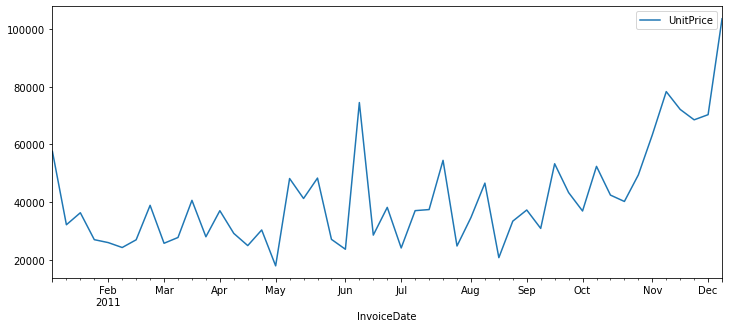

In [28]:
df_1.plot(figsize=(12, 5));

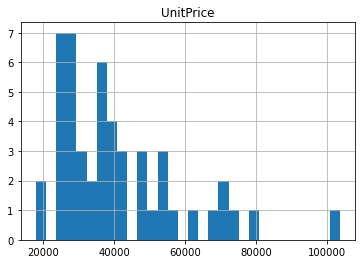

In [29]:
df_1.hist(bins=30);

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

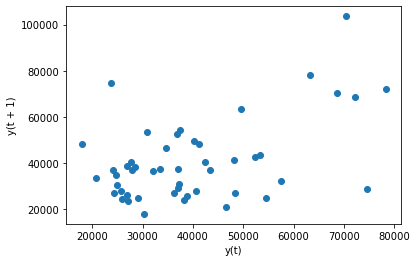

In [30]:
# lag plot
pd.plotting.lag_plot(df_1)

In [31]:
n_lags = 4
lags_df = [df_1["UnitPrice"]]
for n in range(1, n_lags+1):
    lags_df.append(df_1["UnitPrice"].shift(n))
lags_df = pd.concat(lags_df, axis=1)
lags_df.columns = ["base"] + [f"lag_{i}" for i in range(1, n_lags+1)]


In [32]:
lags_df

,base,lag_1,lag_2,lag_3,lag_4
InvoiceDate,,,,,
2011-01-09,57541.340,NaN,NaN,NaN,NaN
2011-01-16,32144.850,57541.340,NaN,NaN,NaN
2011-01-23,36311.250,32144.850,57541.340,NaN,NaN
2011-01-30,26969.650,36311.250,32144.850,57541.340,NaN
2011-02-06,25949.830,26969.650,36311.250,32144.850,57541.340
2011-02-13,24244.620,25949.830,26969.650,36311.250,32144.850
2011-02-20,26918.790,24244.620,25949.830,26969.650,36311.250
2011-02-27,38886.610,26918.790,24244.620,25949.830,26969.650
2011-03-06,25715.700,38886.610,26918.790,24244.620,25949.830


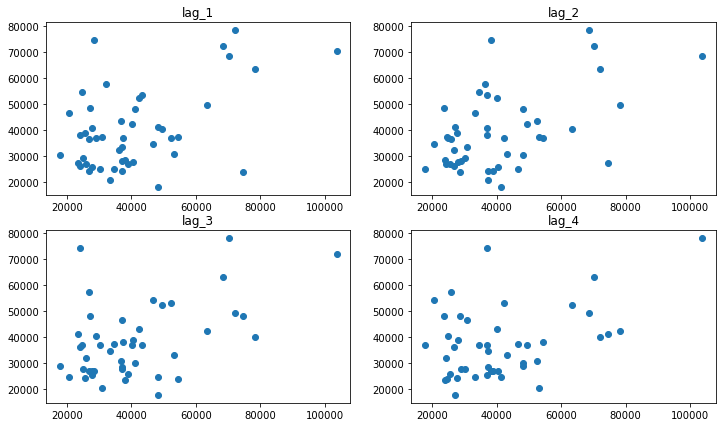

In [33]:
plt.figure(figsize=(12, 7))
for i in range(1, n_lags+1):
    ax = plt.subplot(int(f"22{i}"))
    ax.set_title(f"lag_{i}")
    plt.scatter(lags_df["base"], lags_df[f"lag_{i}"])

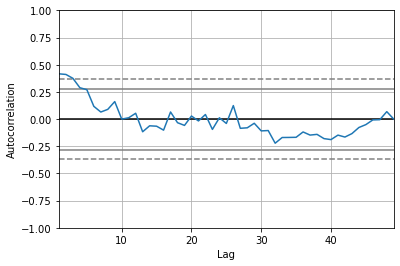

In [34]:
# autocorrelation plot
pd.plotting.autocorrelation_plot(df_1);

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

C:\Users\WIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\WIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


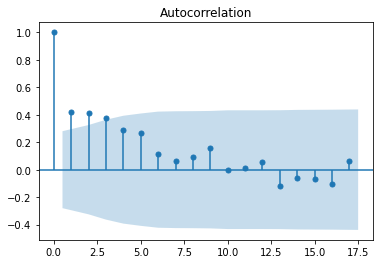

In [36]:
plot_acf(df_1["UnitPrice"].values);

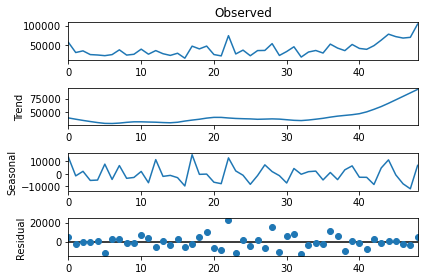

In [57]:
from statsmodels.tsa.seasonal import STL

stl_res = STL(df_1["UnitPrice"].values, period=5).fit()
stl_res.plot();

In [39]:
import sklearn
from sklearn import metrics
sklearn.metrics.r2_score

<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)>

In [40]:
sklearn.metrics.mean_absolute_error

<function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>

In [41]:
sklearn.metrics.median_absolute_error

<function sklearn.metrics._regression.median_absolute_error(y_true, y_pred, *, multioutput='uniform_average', sample_weight=None)>

In [42]:
sklearn.metrics.mean_squared_error

<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [43]:
sklearn.metrics.mean_squared_log_error

<function sklearn.metrics._regression.mean_squared_log_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_1, 24) # prediction for the last observed day (past 24 hours)

48159.550541666664

In [47]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

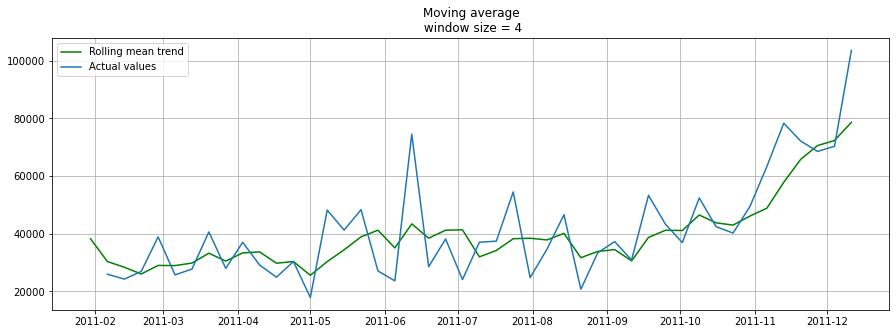

In [48]:
plotMovingAverage(df_1, 4) 

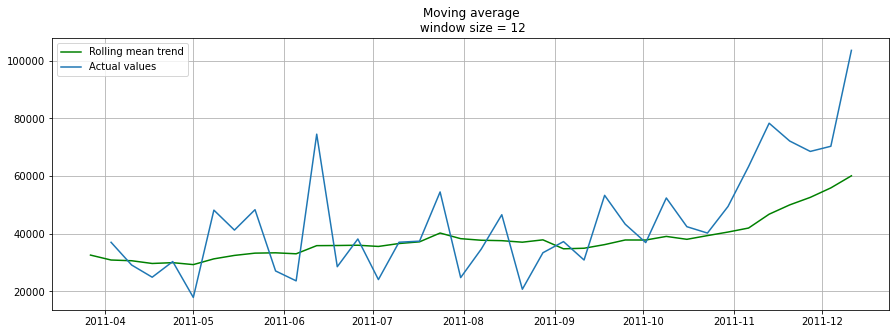

In [49]:
plotMovingAverage(df_1, 12) 

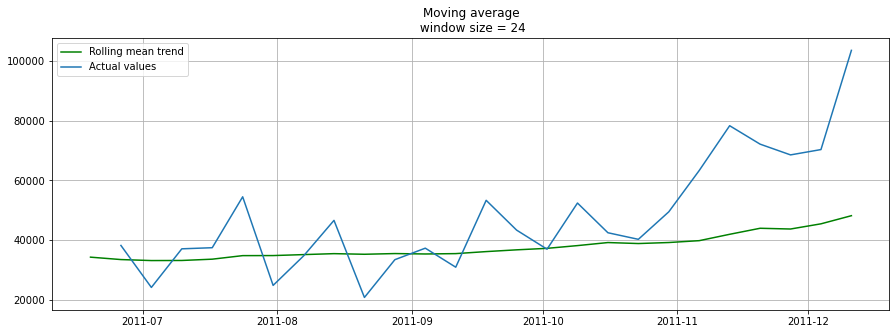

In [50]:
plotMovingAverage(df_1, 24)

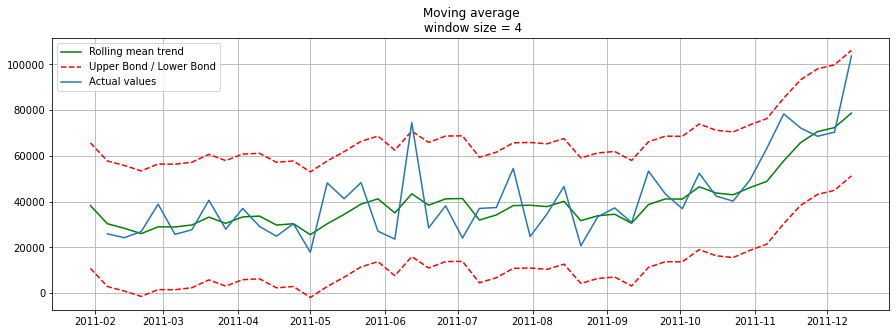

In [51]:
plotMovingAverage(df_1, 4, plot_intervals=True)

# Anomaly detection

In [52]:
df_1_anomaly = df_1.copy()
df_1_anomaly.iloc[-20] = df_1_anomaly.iloc[-20] * 0.2

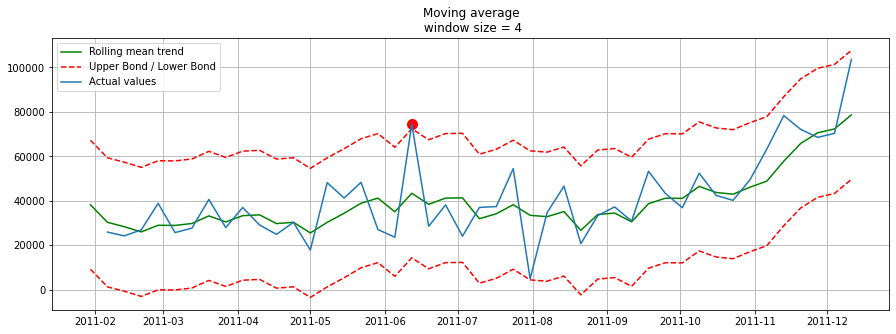

In [53]:
plotMovingAverage(df_1_anomaly, 4, plot_intervals=True, plot_anomalies=True)

In [54]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [55]:
weighted_average(df_1, [0.6, 0.3, 0.1])

90145.547